<a href="https://colab.research.google.com/github/manmeet3/Masters_Project/blob/master/wip_colabs/tumor_anomaly/ganomaly-kaggle-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://www.groundai.com/project/ganomaly-semi-supervised-anomaly-detection-via-adversarial-training/1

https://github.com/chychen/tf2-ganomaly

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/

/content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection


In [4]:
!ls

 archive.zip	       No17.jpg     orig_resized_yes	    resized_yes
 brain_tumor_dataset   no_18.jpg    output		    roc_auc.png
 ckpt		      'no 96.jpg'   pre_rec_curve.png	    source.txt
 ganomaly_tf2	      'no 98.jpg'   resized_no
 No15.jpg	       no.jpg	    resized_no_OASIS-only


In [5]:
# !mkdir ganomaly_tf2
# %cd ganomaly_tf2
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/metrics.py
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/model.py
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/train.py

In [6]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
import os
import time
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ganomaly_tf2.model import GANomaly
from absl import logging
logging.set_verbosity(logging.INFO)
logging.set_stderrthreshold(logging.INFO)

from typing import Any, Callable, Optional, Tuple
from PIL import Image
from sklearn.model_selection import train_test_split

2.4.1


In [7]:
def batch_resize(imgs, size: tuple):
    img_out = np.empty((imgs.shape[0],) + size)
    for i in range(imgs.shape[0]):
        img_out[i] = cv2.resize(imgs[i], size, interpolation=cv2.INTER_CUBIC)
    return img_out

In [8]:
class Option:
    def __init__(self):
        self.anomaly = 1 # the anomaly digit
        self.shuffle_buffer_size = 10000
        self.batch_size = 8
        self.isize = 256 # input size
        self.ckpt_dir = "ckpt"
        self.nz = 100 # latent dims
        self.nc = 1 # input channels
        self.ndf = 64 # number of discriminator's filters
        self.ngf = 64 # number of generator's filters
        self.extralayers = 0
        self.niter = 15 # number of training epochs
        self.lr = 2e-4 
        self.w_adv = 1. # Adversarial loss weight
        self.w_con = 50. # Reconstruction loss weight
        self.w_enc = 1. # Encoder loss weight.
        self.beta1 = 0.5
        self.encdims = None
        self.log_dir = "logs"
        self.dataset = "kaggle_tumor"
            
opt = Option()

In [11]:
if opt.log_dir:
    if not os.path.exists(opt.log_dir):
        os.makedirs(opt.log_dir)
    logging.get_absl_handler().use_absl_log_file(opt.dataset, log_dir=opt.log_dir)

In [12]:
data_train, data_test = tf.keras.datasets.mnist.load_data()
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [13]:
def read_data(path, normal=True):
    data: Any = []
    labels = []
    
    for file_path in glob.glob(path):
        with open (file_path, 'rb') as f:
            # image needs to be a PIL image
            img = Image.open(f).convert('L')
            # image size
            # width, height = img.size
            # mode = img.mode
            # print(f"w: {width} h: {height} mode: {mode}")
            # Resize all images 176, 256, 3 -> 256, 256, 0
            dsize = (256, 256)
            resized = img.resize(dsize)
            # After resize
            # width, height = resized.size
            # mode = resized.mode
            # print(f"RESIZED: w: {width} h: {height} mode: {mode}")
            data.append(resized)
            labels.append(0 if normal else 1) 
            
    data = np.vstack(data).reshape(-1, 256, 256)
    data = data.transpose((0, 1, 2))  # convert to HWC
    return (data, labels)

In [14]:
train_image_number = 140 # Image slice from MRI scans to use for training data
#root_dir = '/content/drive/MyDrive/Masters_Project/Datasets/OASIS3/'
root = '/content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/'
normal_folder = 'resized_no/'
tumor_folder = 'resized_yes/'

normal_jpg_folder = os.path.join(root, normal_folder)
tumor_jpg_folder = os.path.join(root, tumor_folder)
    
print("="*5 + " Loading Data " + "="*5)
print(f"tumor_jpg_folder: {tumor_jpg_folder}")
print(f"normal_jpg_folder: {normal_jpg_folder}")

non_ad_data: Any = []
non_ad_targets = []

ad_data: Any = []
ad_targets = []

# Read data and label into a numpy array
non_ad_data, non_ad_targets = read_data(normal_jpg_folder+'**.jpg', normal=True)
ad_data, ad_targets = read_data(tumor_jpg_folder+'**.jpg', normal=False)

# shuffle the datasets and bucket them as test and train
# (non_ad_data, non_ad_targets) = shuffle_associated_arrays(non_ad_data, non_ad_targets)
# (ad_data, ad_targets) = shuffle_associated_arrays(ad_data, ad_targets)

all_data = np.concatenate((non_ad_data, ad_data), axis=0)
all_targets = non_ad_targets + ad_targets

x_train, x_test, y_train, y_test =\
  train_test_split(all_data, all_targets, test_size=0.1, random_state=42)

===== Loading Data =====
tumor_jpg_folder: /content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/resized_yes/
normal_jpg_folder: /content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/resized_no/


In [15]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

y_train = np.array(y_train, dtype=np.intc)
y_test = np.array(y_test, dtype=np.intc)

In [16]:
print(x_train.shape)
print(x_test.shape)

(645, 256, 256)
(72, 256, 256)


In [17]:
x_train = batch_resize(x_train, (256, 256))[..., None]
x_test = batch_resize(x_test, (256, 256))[..., None]
# normalization
mean = x_train.mean()
stddev = x_train.std()
x_train = (x_train-mean)/stddev
x_test = (x_test-mean)/stddev
print(x_train.shape, x_train.shape)
# define abnoraml data and normal
# training data only contains normal
x_train = x_train[y_train!=opt.anomaly]
y_train = y_train[y_train!=opt.anomaly]
y_test = (y_test==opt.anomaly).astype(np.float32)
# tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_dataset = train_dataset.shuffle(opt.shuffle_buffer_size).batch(opt.batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(opt.batch_size, drop_remainder=False)

(645, 256, 256, 1) (645, 256, 256, 1)


In [18]:
train_dataset

<BatchDataset shapes: ((8, 256, 256, 1), (8,)), types: (tf.float64, tf.int32)>

In [19]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float64, tf.float32)>

In [20]:
ganomaly = GANomaly(opt, train_dataset, valid_dataset=None, test_dataset=test_dataset)

In [21]:
ganomaly.fit(opt.niter)

INFO:absl:epoch: 0, G_losses: 44.0436, D_losses: 3.5896, samples/sec: 7.2666


INFO:tensorflow:Assets written to: ckpt/gen/assets


INFO:tensorflow:Assets written to: ckpt/gen/assets


INFO:tensorflow:Assets written to: ckpt/disc/assets


INFO:tensorflow:Assets written to: ckpt/disc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.4516   average_precision: 0.8388 ***


INFO:absl:re-init D, cost: 0.1604 secs
INFO:absl:epoch: 1, G_losses: 43.9997, D_losses: 4.5587, samples/sec: 22.2326


INFO:absl:	 Testing:   roc_auc: 0.4274   average_precision: 0.8543


INFO:absl:epoch: 2, G_losses: 45.9068, D_losses: 2.9970, samples/sec: 23.6769


INFO:absl:	 Testing:   roc_auc: 0.4065   average_precision: 0.8237


INFO:absl:epoch: 3, G_losses: 49.0568, D_losses: 2.2239, samples/sec: 22.7806


INFO:tensorflow:Assets written to: ckpt/gen/assets


INFO:tensorflow:Assets written to: ckpt/gen/assets


INFO:tensorflow:Assets written to: ckpt/disc/assets


INFO:tensorflow:Assets written to: ckpt/disc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.6419   average_precision: 0.9220 ***


INFO:absl:epoch: 4, G_losses: 62.3372, D_losses: 4.2614, samples/sec: 23.3595


INFO:tensorflow:Assets written to: ckpt/gen/assets


INFO:tensorflow:Assets written to: ckpt/gen/assets


INFO:tensorflow:Assets written to: ckpt/disc/assets


INFO:tensorflow:Assets written to: ckpt/disc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.7855   average_precision: 0.9618 ***


INFO:absl:epoch: 5, G_losses: 431.0058, D_losses: 7.4944, samples/sec: 23.1881


INFO:absl:	 Testing:   roc_auc: 0.5806   average_precision: 0.8915


INFO:absl:epoch: 6, G_losses: 91.6417, D_losses: 7.4919, samples/sec: 23.2683


INFO:tensorflow:Assets written to: ckpt/gen/assets


INFO:tensorflow:Assets written to: ckpt/gen/assets


INFO:tensorflow:Assets written to: ckpt/disc/assets


INFO:tensorflow:Assets written to: ckpt/disc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.7984   average_precision: 0.9643 ***


INFO:absl:epoch: 7, G_losses: 53.4888, D_losses: 7.3934, samples/sec: 23.2663


INFO:absl:	 Testing:   roc_auc: 0.6919   average_precision: 0.9454


INFO:absl:epoch: 8, G_losses: 41.7483, D_losses: 7.7125, samples/sec: 23.9974


INFO:absl:	 Testing:   roc_auc: 0.6113   average_precision: 0.9297


INFO:absl:epoch: 9, G_losses: 40.3276, D_losses: 7.7125, samples/sec: 23.3792


INFO:absl:	 Testing:   roc_auc: 0.6065   average_precision: 0.9283


INFO:absl:epoch: 10, G_losses: 40.3073, D_losses: 7.7125, samples/sec: 23.3947


INFO:absl:	 Testing:   roc_auc: 0.4532   average_precision: 0.8817


INFO:absl:epoch: 11, G_losses: 39.2420, D_losses: 7.7125, samples/sec: 23.8608


INFO:absl:	 Testing:   roc_auc: 0.6290   average_precision: 0.9333


INFO:absl:epoch: 12, G_losses: 38.8654, D_losses: 7.7125, samples/sec: 24.2006


INFO:absl:	 Testing:   roc_auc: 0.6726   average_precision: 0.9450


INFO:absl:epoch: 13, G_losses: 38.0311, D_losses: 7.7125, samples/sec: 24.3700


INFO:absl:	 Testing:   roc_auc: 0.4645   average_precision: 0.8842


INFO:absl:epoch: 14, G_losses: 35.8743, D_losses: 7.7125, samples/sec: 24.1145


INFO:absl:	 Testing:   roc_auc: 0.7048   average_precision: 0.9500


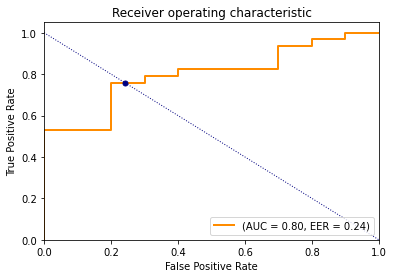

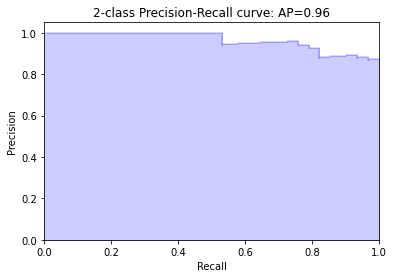

In [22]:
ganomaly.evaluate_best(test_dataset)

# Test

In [39]:
from PIL import Image as im

In [26]:
# Load the last saved model
D = tf.keras.models.load_model('ckpt/disc')

In [42]:
test_x = np.concatenate([x for x, y in test_dataset], axis=0)
test_y = np.concatenate([y for x, y in test_dataset], axis=0)

Populating the interactive namespace from numpy and matplotlib


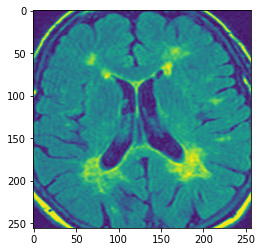

In [60]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = np.reshape(test_x[19],(256,256)) # 3, 12, 18
plt.imshow(img)
plt.show()

In [44]:
test_y

array([1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 0.], dtype=float32)

In [29]:
D.predict(test_dataset)

(array([[[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[[1.]]],
 
 
        [[